In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from matplotlib.ticker import PercentFormatter
import warnings
warnings.filterwarnings('ignore')


In [19]:

class FinancialVisualizer:
    def __init__(self, data, returns):
        """
        Initialize with financial data and returns series
        
        Parameters:
        - data: pd.DataFrame with financial data
        - returns: np.array or pd.Series of returns
        """
        self.data = data
        self.returns = returns
        
        # Set style properly
        plt.style.use('seaborn-v0_8-darkgrid')  # or any other valid style
        sns.set_theme()
        sns.set_palette("husl")
        
        # Set default figure parameters
        plt.rcParams['figure.figsize'] = [12, 8]
        plt.rcParams['figure.dpi'] = 100
        plt.rcParams['axes.grid'] = True
        plt.rcParams['grid.alpha'] = 0.3
        plt.rcParams['axes.labelsize'] = 12
        plt.rcParams['axes.titlesize'] = 14
        plt.rcParams['xtick.labelsize'] = 10
        plt.rcParams['ytick.labelsize'] = 10
        
    def create_dashboard(self, figsize=(20, 12)):
        """Create comprehensive financial dashboard"""
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(3, 3, figure=fig)
        
        # 1. Returns Distribution
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_returns_distribution(ax1)
        
        # 2. QQ Plot
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_qq(ax2)
        
        # 3. Time Series with Volatility
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_timeseries_volatility(ax3)
        
        # 4. Rolling Statistics
        ax4 = fig.add_subplot(gs[1, 0])
        self._plot_rolling_statistics(ax4)
        
        # 5. Drawdown Analysis
        ax5 = fig.add_subplot(gs[1, 1])
        self._plot_drawdown(ax5)
        
        # 6. ACF/PACF
        ax6 = fig.add_subplot(gs[1, 2])
        self._plot_autocorrelation(ax6)
        
        # 7. Volume Profile
        ax7 = fig.add_subplot(gs[2, 0])
        self._plot_volume_profile(ax7)
        
        # 8. Return Decomposition
        ax8 = fig.add_subplot(gs[2, 1])
        self._plot_return_decomposition(ax8)
        
        # 9. Risk Metrics
        ax9 = fig.add_subplot(gs[2, 2])
        self._plot_risk_metrics(ax9)
        
        plt.tight_layout()
        return fig
    
    def _plot_returns_distribution(self, ax):
        """Plot returns distribution with normal overlay"""
        sns.histplot(self.returns, stat='density', alpha=0.3, ax=ax)
        sns.kdeplot(self.returns, ax=ax, color='darkblue')
        
        # Add normal distribution
        x = np.linspace(min(self.returns), max(self.returns), 100)
        normal_dist = stats.norm.pdf(x, np.mean(self.returns), np.std(self.returns))
        ax.plot(x, normal_dist, 'r--', label='Normal Distribution')
        
        # Add statistical annotations
        skew = stats.skew(self.returns)
        kurt = stats.kurtosis(self.returns)
        ax.text(0.05, 0.95, f'Skewness: {skew:.2f}\nKurtosis: {kurt:.2f}',
                transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
        
        ax.set_title('Returns Distribution')
        ax.legend()
    
    def _plot_qq(self, ax):
        """Create Q-Q plot with confidence bands"""
        stats.probplot(self.returns, dist="norm", plot=ax)
        ax.set_title('Q-Q Plot')
    
    def _plot_timeseries_volatility(self, ax):
        """Plot returns time series with volatility bands"""
        rolling_std = pd.Series(self.returns).rolling(window=21).std()
        ax.plot(self.returns, alpha=0.5, label='Returns')
        ax.plot(rolling_std, color='red', label='Rolling Volatility (21d)')
        ax.set_title('Returns and Volatility')
        ax.legend()
    
    def _plot_rolling_statistics(self, ax):
        """Plot rolling mean and standard deviation"""
        returns_series = pd.Series(self.returns)
        rolling_mean = returns_series.rolling(window=21).mean()
        rolling_std = returns_series.rolling(window=21).std()
        
        ax.plot(rolling_mean, label='Rolling Mean (21d)')
        ax.fill_between(range(len(rolling_mean)),
                       rolling_mean - 2*rolling_std,
                       rolling_mean + 2*rolling_std,
                       alpha=0.2, label='±2σ Band')
        ax.set_title('Rolling Statistics')
        ax.legend()
    
    def _plot_drawdown(self, ax):
        """Plot drawdown analysis"""
        cumulative_returns = (1 + pd.Series(self.returns)).cumprod()
        running_max = cumulative_returns.expanding().max()
        drawdowns = (cumulative_returns - running_max) / running_max
        
        ax.fill_between(range(len(drawdowns)), drawdowns, 0, alpha=0.3, color='red')
        ax.set_title(f'Drawdown Analysis\nMax Drawdown: {drawdowns.min():.2%}')
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    def _plot_autocorrelation(self, ax):
        """Plot autocorrelation function"""
        from statsmodels.graphics.tsaplots import plot_acf
        plot_acf(self.returns, ax=ax, lags=30, alpha=0.05)
        ax.set_title('Autocorrelation Function')
    
    def _plot_volume_profile(self, ax):
        """Plot volume profile"""
        if 'Volume' in self.data.columns:
            volume_profile = self.data.groupby(pd.qcut(self.data['Price'], 20))['Volume'].sum()
            ax.barh(range(len(volume_profile)), volume_profile.values)
            ax.set_title('Volume Profile')
            ax.set_ylabel('Price Levels')
    
    def _plot_return_decomposition(self, ax):
        """Plot return decomposition by time periods"""
        daily_returns = pd.Series(self.returns)
        weekly_returns = daily_returns.resample('W').sum()
        monthly_returns = daily_returns.resample('M').sum()
        
        ax.boxplot([daily_returns, weekly_returns, monthly_returns],
                  labels=['Daily', 'Weekly', 'Monthly'])
        ax.set_title('Return Decomposition')
        ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    def _plot_risk_metrics(self, ax):
        """Plot risk metrics summary"""
        ax.axis('off')
        
        # Calculate risk metrics
        vol = np.std(self.returns) * np.sqrt(252)
        sharpe = np.mean(self.returns) / np.std(self.returns) * np.sqrt(252)
        var_95 = np.percentile(self.returns, 5)
        
        metrics = {
            'Annual Volatility': f'{vol:.2%}',
            'Sharpe Ratio': f'{sharpe:.2f}',
            'Value at Risk (95%)': f'{var_95:.2%}',
            'Skewness': f'{stats.skew(self.returns):.2f}',
            'Kurtosis': f'{stats.kurtosis(self.returns):.2f}'
        }
        
        # Create text box
        text = '\n'.join([f'{k}: {v}' for k, v in metrics.items()])
        ax.text(0.1, 0.9, text, bbox=dict(facecolor='white', alpha=0.8))
        ax.set_title('Risk Metrics')
        
def add_technical_analysis_plots(self):
    """Add technical analysis plots to the FinancialVisualizer class"""
    
    def plot_moving_averages(self, fig, gs):
        """Plot price with multiple moving averages"""
        ax = fig.add_subplot(gs[0, :2])
        
        # Plot price
        ax.plot(self.data.index, self.data['Price'], label='Price', alpha=0.7)
        
        # Calculate and plot moving averages
        for period in [20, 50, 200]:
            ma = self.data['Price'].rolling(window=period).mean()
            ax.plot(self.data.index, ma, label=f'{period}-day MA')
        
        ax.set_title('Price and Moving Averages')
        ax.legend()
        return ax

    def plot_rsi(self, fig, gs):
        """Plot RSI indicator"""
        ax = fig.add_subplot(gs[1, 0])
        
        # Calculate RSI
        def calculate_rsi(data, periods=14):
            delta = data.diff()
            gain = (delta.where(delta > 0, 0)).rolling(window=periods).mean()
            loss = (-delta.where(delta < 0, 0)).rolling(window=periods).mean()
            rs = gain / loss
            return 100 - (100 / (1 + rs))
        
        rsi = calculate_rsi(self.data['Price'])
        
        # Plot RSI
        ax.plot(self.data.index, rsi, label='RSI')
        ax.axhline(y=70, color='r', linestyle='--', alpha=0.5)
        ax.axhline(y=30, color='g', linestyle='--', alpha=0.5)
        ax.fill_between(self.data.index, 70, 30, alpha=0.1, color='gray')
        
        ax.set_title('Relative Strength Index (RSI)')
        ax.set_ylim(0, 100)
        return ax

    def plot_bollinger_bands(self, fig, gs):
        """Plot Bollinger Bands"""
        ax = fig.add_subplot(gs[1, 1])
        
        # Calculate Bollinger Bands
        rolling_mean = self.data['Price'].rolling(window=20).mean()
        rolling_std = self.data['Price'].rolling(window=20).std()
        upper_band = rolling_mean + (rolling_std * 2)
        lower_band = rolling_mean - (rolling_std * 2)
        
        # Plot bands
        ax.plot(self.data.index, self.data['Price'], label='Price')
        ax.plot(self.data.index, rolling_mean, label='20-day MA')
        ax.plot(self.data.index, upper_band, 'r--', label='Upper Band')
        ax.plot(self.data.index, lower_band, 'g--', label='Lower Band')
        ax.fill_between(self.data.index, upper_band, lower_band, alpha=0.1)
        
        ax.set_title('Bollinger Bands')
        ax.legend()
        return ax

    def plot_macd(self, fig, gs):
        """Plot MACD indicator"""
        ax = fig.add_subplot(gs[1, 2])
        
        # Calculate MACD
        exp1 = self.data['Price'].ewm(span=12, adjust=False).mean()
        exp2 = self.data['Price'].ewm(span=26, adjust=False).mean()
        macd = exp1 - exp2
        signal = macd.ewm(span=9, adjust=False).mean()
        histogram = macd - signal
        
        # Plot MACD
        ax.plot(self.data.index, macd, label='MACD')
        ax.plot(self.data.index, signal, label='Signal')
        ax.bar(self.data.index, histogram, alpha=0.3, label='Histogram')
        
        ax.set_title('MACD')
        ax.legend()
        return ax

    # Update create_dashboard method to include new plots
    def create_technical_dashboard(self, figsize=(20, 12)):
        """Create technical analysis dashboard"""
        fig = plt.figure(figsize=figsize)
        gs = GridSpec(3, 3, figure=fig)
        
        # Plot all indicators
        self.plot_moving_averages(fig, gs)
        self.plot_rsi(fig, gs)
        self.plot_bollinger_bands(fig, gs)
        self.plot_macd(fig, gs)
        
        plt.tight_layout()
        return fig


In [20]:

# Example usage:
def create_sample_data(n_days=252):
    """Create sample financial data"""
    np.random.seed(42)
    dates = pd.date_range(start='2023-01-01', periods=n_days, freq='B')
    
    # Generate returns with slight skewness and fat tails
    returns = np.random.normal(0.0005, 0.01, n_days)
    returns = returns + 0.1 * returns**3
    returns = returns + np.random.standard_t(df=5, size=n_days) * 0.002
    
    # Create price series
    prices = 100 * np.exp(np.cumsum(returns))
    
    df = pd.DataFrame({
        'Date': dates,
        'Price': prices,
        'Returns': returns,
        'Volume': np.random.lognormal(10, 1, n_days)
    })
    return df, returns


In [21]:

# Create and display dashboard
df, returns = create_sample_data()


In [22]:
visualizer = FinancialVisualizer(df, returns)


TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'RangeIndex'

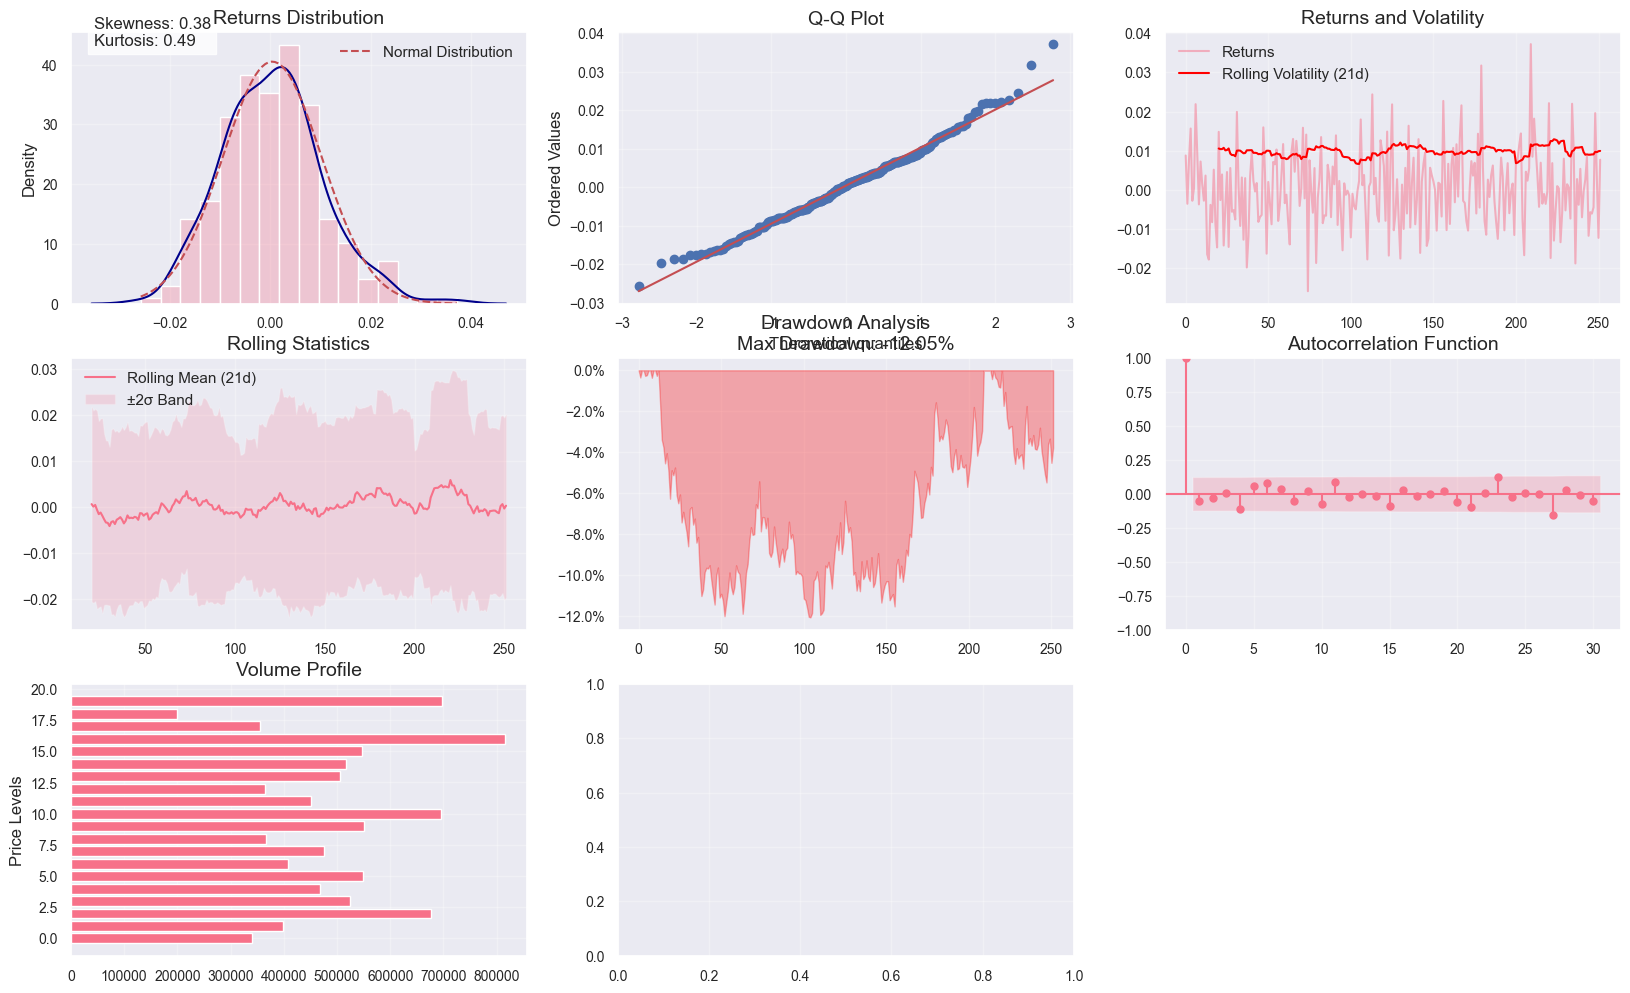

In [23]:
dashboard = visualizer.create_dashboard()
plt.show()